In [1]:
import os
import sys
import yaml
import pandas as pd
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
from src.utils.general import get_db_conn, get_boto3_session
from src.utils import project_constants as constants

In [3]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage import create_engine

In [4]:
cred_file = '../conf/local/credentials.yaml'
engine=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

#### db connection 

In [5]:
with open(cred_file) as f:
    db_config = yaml.load(f)['db']

db_url = URL(
    'postgres',
    host=db_config['host'],
    username=db_config['user'],
    database=db_config['db'],
    password=db_config['pass'],
    port=db_config['port'],
)

db_con = create_engine(db_url)

/home/kasun/.pyenv/versions/aclu/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [6]:
# experiment_hash = '102f4996db3d114aa68dda958d1446cc'
experiment_hash = 'c11db389a7490536504225c05359a149'
# experiment_hash = '6c185dd4b5d63791b315c5412b6144a9'

### Preaudition

In [7]:
pre_aud = PreAudition(db_con)

model_groups = pre_aud.get_model_groups_from_experiment(experiment_hash)
# end_times = pre_aud.get_train_end_times(after='2011-01-01')

In [8]:
print(model_groups)
len(model_groups)

[477, 350, 424, 406, 509, 417, 475, 390, 502, 440, 349, 506, 508, 357, 366, 466, 446, 400, 363, 512, 340, 356, 487, 458, 414, 368, 344, 410, 428, 355, 381, 359, 453, 501, 496, 485, 481, 438, 378, 341, 483, 450, 405, 513, 473, 375, 415, 408, 401, 507, 419, 457, 409, 398, 418, 407, 387, 443, 484, 471, 393, 464, 498, 469, 342, 488, 360, 463, 476, 374, 439, 423, 442, 354, 479, 411, 425, 495, 474, 403, 422, 380, 486, 435, 384, 351, 386, 431, 426, 433, 364, 491, 462, 345, 436, 437, 470, 454, 482, 500, 478, 505, 420, 461, 447, 468, 456, 397, 427, 347, 361, 402, 472, 444, 445, 343, 467, 497, 416, 372, 369, 441, 339, 383, 503, 377, 432, 517, 455, 346, 448, 396, 511, 514, 389, 451, 348, 504, 399, 452, 490, 480, 358, 412, 510, 404, 353, 489, 515, 516, 395, 352, 362, 430, 460, 499, 459, 371, 492, 365, 413, 421, 392, 429, 434, 465, 449]


167

#### Model groups

In [9]:
# q = """
#     select distinct(model_group_id) from triage_metadata.models where built_by_experiment='{exp_hash}'
# """.format(
#     exp_hash=experiment_hash
# )
# df = pd.read_sql(q, db_con)
# model_groups = df['model_group_id'].tolist()

#### Train end times

In [10]:
q = """
    select 
        distinct(train_end_time) 
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash) 
    where experiment_hash='{exp_hash}' order by train_end_time
""".format(
    exp_hash=experiment_hash
)
df = pd.read_sql(q, db_con)
train_end_times =  df['train_end_time'].tolist()

In [11]:
train_end_times

[Timestamp('2012-07-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2013-07-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00')]

#### Initial Metric filters

In [15]:
metric_filters = [
    {
        'metric': 'precision@',
        'parameter': '1000_abs',
        'max_from_best': 1,
        'threshold_value': 0  
    }
]


# metric_filters = [
# {
#     'metric': 'precision@',
#     'parameter': '10_pct',
#     'max_from_best': 0.01,
#     'threshold_value': 0.65
# }, 
# {
#     'metric': 'precision@',
#     'parameter': '20_pct',
#     'max_from_best': 0.01,
#     'threshold_value': 0.55
# }, 
# {
#     'metric': 'precision@',
#     'parameter': '30_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.4
# }, 
# {
#     'metric': 'precision@',
#     'parameter': '40_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.3
# },    
# {
#     'metric': 'recall@',
#     'parameter': '10_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.15
# }, 
# {
#     'metric': 'recall@',
#     'parameter': '20_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.3
# }, 
# {
#     'metric': 'recall@',
#     'parameter': '30_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.45
# }, 
# {
#     'metric': 'recall@',
#     'parameter': '40_pct',
#     'max_from_best': 0.1,
#     'threshold_value': 0.65
# }
# ]

# metric_filters = [{
#     'metric': 'precision@',
#     'parameter': '40_pct',
#     'max_from_best': 1,
#     'threshold_value': 0.0
# },
# {
#     'metric': 'recall@',
#     'parameter': '40_pct',
#     'max_from_best': 1,
#     'threshold_value': 0.0
# }

# ]

In [16]:
aud = Auditioner(
    db_engine=db_con,
    model_group_ids=model_groups,
    train_end_times=train_end_times,
    initial_metric_filters=metric_filters,
    models_table='models',
    distance_table='best_dist_long_term'
)

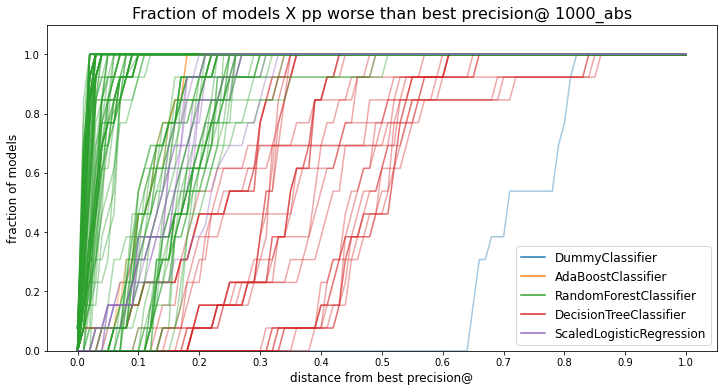

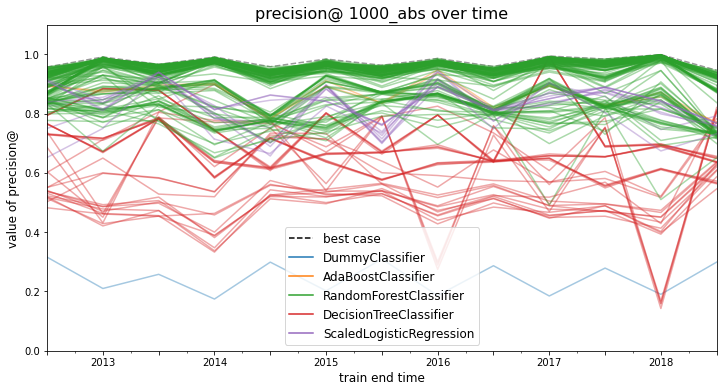

In [17]:
%matplotlib inline
aud.plot_model_groups()

In [205]:
ids = aud.thresholded_model_group_ids
# ids

In [206]:
len(ids)

41

#### Rules Maker

In [96]:
from triage.component.audition.rules_maker import (
    SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid
)

In [207]:
rule1 =  SimpleRuleMaker()
rule1.add_rule_best_current_value(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_best_average_value(metric='precision@', parameter='10_pct', n=3)
rule1.add_rule_best_avg_recency_weight(metric='precision@', parameter='10_pct', n=3, decay_type='linear')
rule1.add_rule_lowest_metric_variance(metric='precision@', parameter=parameter, n=3)

rule1.add_rule_best_current_value(metric='precision@', parameter='20_pct', n=3)
rule1.add_rule_best_average_value(metric='precision@', parameter='20_pct', n=3)
rule1.add_rule_best_avg_recency_weight(metric='precision@', parameter='20_pct', n=3, decay_type='linear')
rule1.add_rule_lowest_metric_variance(metric='precision@', parameter=parameter, n=3)

rule1.add_rule_best_current_value(metric='recall@', parameter='10_pct', n=3)
rule1.add_rule_best_average_value(metric='recall@', parameter='10_pct', n=3)
rule1.add_rule_best_avg_recency_weight(metric='recall@', parameter='10_pct', n=3, decay_type='linear')
rule1.add_rule_lowest_metric_variance(metric='recall@', parameter=parameter, n=3)

rule1.add_rule_best_current_value(metric='recall@', parameter='20_pct', n=3)
rule1.add_rule_best_average_value(metric='recall@', parameter='20_pct', n=3)
rule1.add_rule_best_avg_recency_weight(metric='recall@', parameter='20_pct', n=3, decay_type='linear')
rule1.add_rule_lowest_metric_variance(metric='recall@', parameter=parameter, n=3)

rule2 = RandomGroupRuleMaker(n=1)
rules = create_selection_grid(rule1, rule2)

In [208]:
aud.register_selection_rule_grid(rules, plot=False)

In [87]:
# dir(aud.distance_from_best_table)

In [88]:
# aud.distance_from_best_table.as_dataframe(model_group_ids=model_groups)

In [89]:
# !pip show triage

In [99]:
# t = aud.results_for_rule['best_current_value_recall@_10_pct'].sort_values(['selection_rule', 'train_end_time'], ascending=[True, False])

# msk = (t['model_group_id'] == 472)
# t[msk]
# t.head(20)

In [209]:
aud.selection_rule_model_group_ids

{'best_current_value_precision@_10_pct': [366, 484, 472],
 'best_average_value_precision@_10_pct': [484, 472, 375],
 'best_avg_recency_weight_precision@_10_pct_1.5_linear': [484, 472, 375],
 'best_avg_recency_weight_precision@_10_pct_2.0_linear': [484, 472, 375],
 'best_avg_recency_weight_precision@_10_pct_5.0_linear': [484, 366, 472],
 'lowest_metric_variance_precision@_10_pct': [471, 365, 478],
 'best_current_value_precision@_20_pct': [386, 472, 472],
 'best_average_value_precision@_20_pct': [472, 384, 484],
 'best_avg_recency_weight_precision@_20_pct_1.5_linear': [472, 384, 484],
 'best_avg_recency_weight_precision@_20_pct_2.0_linear': [472, 384, 484],
 'best_avg_recency_weight_precision@_20_pct_5.0_linear': [472, 484, 384],
 'lowest_metric_variance_precision@_20_pct': [380, 371, 475],
 'best_current_value_recall@_10_pct': [366, 484, 472],
 'best_average_value_recall@_10_pct': [484, 472, 375],
 'best_avg_recency_weight_recall@_10_pct_1.5_linear': [484, 472, 375],
 'best_avg_recency_

In [210]:
model_group_list = list()
for rule, models in aud.selection_rule_model_group_ids.items():
    if rule == 'random_model_group':
        continue
    model_group_list = model_group_list + models

In [237]:
print(set(model_group_list))

{384, 386, 484, 490, 460, 365, 366, 462, 371, 471, 472, 474, 475, 380, 478, 375}


In [211]:
q = """select 
        model_group_id,
        model_type, 
        hyperparameters ->> 'max_depth' as max_depth, 
        hyperparameters ->> 'n_estimators' as n_estimators,
        hyperparameters
    from triage_metadata.model_groups 
    where model_group_id in {}""".format(tuple(model_group_list))

pd.read_sql(q, db_con)

,model_group_id,model_type,max_depth,n_estimators,hyperparameters
0,365,sklearn.ensemble.RandomForestClassifier,25,100,"{'criterion': 'gini', 'max_depth': 25, 'class_..."
1,366,sklearn.ensemble.RandomForestClassifier,25,1000,"{'criterion': 'gini', 'max_depth': 25, 'class_..."
2,371,sklearn.ensemble.RandomForestClassifier,25,100,"{'criterion': 'gini', 'max_depth': 25, 'class_..."
3,375,sklearn.ensemble.RandomForestClassifier,50,1000,"{'criterion': 'gini', 'max_depth': 50, 'class_..."
4,380,sklearn.ensemble.RandomForestClassifier,50,100,"{'criterion': 'gini', 'max_depth': 50, 'class_..."
5,384,sklearn.ensemble.RandomForestClassifier,100,1000,"{'criterion': 'gini', 'max_depth': 100, 'class..."
6,386,sklearn.ensemble.RandomForestClassifier,100,100,"{'criterion': 'gini', 'max_depth': 100, 'class..."
7,460,sklearn.ensemble.RandomForestClassifier,25,2000,"{'criterion': 'gini', 'max_depth': 25, 'class_..."
8,462,sklearn.ensemble.RandomForestClassifier,25,25,"{'criterion': 'gini', 'max_depth': 25, 'class_..."
9,471,sklearn.ensemble.RandomForestClassifier,50,50,"{'criterion': 'gini', 'max_depth': 50, 'class_..."


In [251]:
metric='precision@'
# parameters=['10_pct', '20_pct', '30_pct', '40_pct']
# parameters = [' ','20_pct']

# parameters=['20_pct', '10_pct', '30_pct', '100_pct']
parameters=['20_pct', '10_pct']

eval_q = """
    select 
        model_id,
        model_group_id,
        hyperparameters,
        model_type,
        metric,
        parameter,
        stochastic_value as metric_value,
        train_end_time
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash) join test_results.evaluations using(model_id)
    where experiment_hash='{exp_hash}'
    and metric='{metric}' and "parameter" in {param}
    and model_group_id in {mod_groups}
    --and model_type not like '%dummy%'
"""

precision = pd.read_sql(
    eval_q.format(
        exp_hash=experiment_hash,
        metric=metric,
        param=tuple(parameters),
#         mod_groups=tuple(model_group_list)
        mod_groups = (365, 375, 472, 371)
    ), 
    engine
)

In [252]:
precision['hyperparameters_2'] = precision.apply(lambda x:str(x['hyperparameters']) + '_' +str(x['model_group_id']), axis=1)

Text(0.5, 1.0, "precision@['20_pct', '10_pct'] over time for the model groups tested")

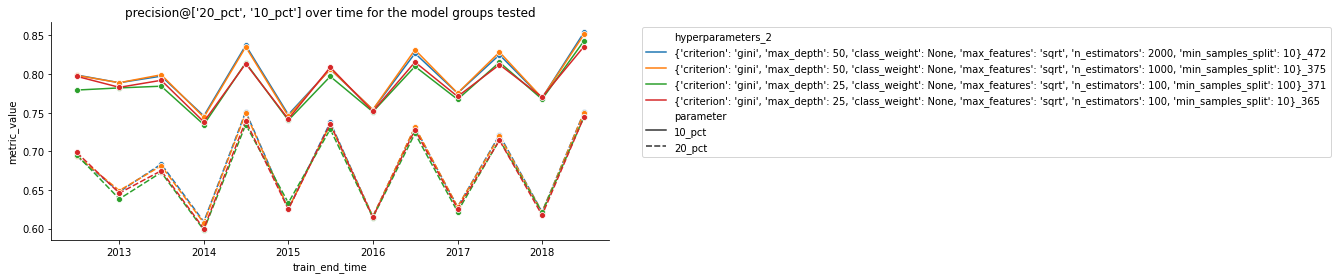

In [253]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.lineplot(data=precision, x='train_end_time', y='metric_value',
             hue='hyperparameters_2', 
             marker='o', 
             style='parameter', 
             estimator='mean', ci='sd', alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1))
# ax.set_ylim(0, 1)
ax.set_title('{}{} over time for the model groups tested'.format(metric, parameters))